<a href="https://colab.research.google.com/github/lacykaltgr/ait-assessments/blob/main/11_Huggingface_Text_Classification_assessment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Assessment: Classifying authors with DistilBERT
Please use the HuggingFace Transformer library for author classification:
* use the DistilBERT architecture this time,
* collect data from 4 authors,
* create, train and evaluate a classifier with DistilBERT and 4 authors.



In [1]:
%%capture
!pip install tensorflow transformers
!python -m spacy download en

In [2]:
import tensorflow as tf
from tensorflow.keras import activations, optimizers, losses
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
import pickle
import spacy
from urllib.request import urlretrieve
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

## 1. Exercise: Dataset acquisition

In [3]:
nlp = spacy.load("en_core_web_sm")

def sentencesSplit(raw_text):
  doc = nlp(raw_text)
  sentences = [sent.text for sent in doc.sents]
  return sentences


In [4]:
book1="http://www.gutenberg.org/files/2151/2151-0.txt"
book2="https://www.gutenberg.org/cache/epub/70589/pg70589.txt"
book3="https://www.gutenberg.org/ebooks/64317.txt.utf-8"
book4="https://www.gutenberg.org/files/16/16-0.txt"
urlretrieve(book1, 'book1.txt')
urlretrieve(book2, 'book2.txt')
urlretrieve(book3, 'book3.txt')
urlretrieve(book4, 'book4.txt')
book1_text = open("book1.txt", encoding='utf-8').read().lower()
book2_text = open("book2.txt", encoding='utf-8').read().lower()
book3_text = open("book3.txt", encoding='utf-8').read().lower()
book4_text = open("book4.txt", encoding='utf-8').read().lower()

In [5]:
book1_sents = sentencesSplit(book1_text)
book2_sents = sentencesSplit(book2_text)
book3_sents = sentencesSplit(book3_text)
book4_sents = sentencesSplit(book4_text)

In [6]:
TRAIN_SIZE = 0.8
t_split_1  = int(TRAIN_SIZE*len(book1_sents))
t_split_2  = int(TRAIN_SIZE*len(book2_sents))
t_split_3  = int(TRAIN_SIZE*len(book3_sents))
t_split_4  = int(TRAIN_SIZE*len(book4_sents))

In [7]:
print(t_split_1)
print(t_split_2)
print(t_split_3)
print(t_split_4)

2451
2780
2416
2256


In [8]:
from keras.utils import to_categorical

X_train = book1_sents[:t_split_1] \
        + book2_sents[:t_split_2] \
        + book3_sents[:t_split_3] \
        + book3_sents[:t_split_4]
Y_train = np.concatenate((
    to_categorical(np.full(t_split_1, 0), num_classes=4),
    to_categorical(np.full(t_split_2, 1), num_classes=4),
    to_categorical(np.full(t_split_3, 2), num_classes=4), 
    to_categorical(np.full(t_split_4, 3), num_classes=4)
))

X_test  = book1_sents[t_split_1:]  \
    + book2_sents[t_split_2:]      \
    + book3_sents[t_split_3:]      \
    + book4_sents[t_split_4:]   

Y_test = np.concatenate((
    to_categorical(np.full(len(book1_sents)-t_split_1, 0), num_classes=4),
    to_categorical(np.full(len(book2_sents)-t_split_2, 1), num_classes=4),
    to_categorical(np.full(len(book3_sents)-t_split_3, 2), num_classes=4),
    to_categorical(np.full(len(book4_sents)-t_split_4, 3), num_classes=4)
))

# 2. Exercise: Data preparation

We are using [DisitlBERT](https://huggingface.co/transformers/model_doc/distilbert.html) model, in which we have to convert each sentence into a tuple containing the text's [input ids](https://huggingface.co/transformers/glossary.html#input-ids) and the corresponding [attention masks](https://huggingface.co/transformers/glossary.html#attention-mask). In order to do so, the corresponding tokizer can be used: [DistilBertTokenizer](https://huggingface.co/transformers/model_doc/distilbert.html#distilberttokenizer)

We trim or pad the processed sentences to MAX_LEN (due to `truncation=True` and `padding=True` parameters) - this is an easy solution to handle inputs with different lengths.

In [9]:
MODEL_NAME = 'distilbert-base-uncased'
MAX_LEN = 50

sample = X_train[1100]

tokenizer = DistilBertTokenizer.from_pretrained(MODEL_NAME)
inputs = tokenizer(sample)

print(f'sentence: \'{sample}\'')
print(f'input ids: {inputs["input_ids"]}')
print(f'attention mask: {inputs["attention_mask"]}')

sentence: 'here replied bon-bon, and his majesty proceeded:

      “but if i have a penchant, monsieur bon-bon—if i have a penchant, it
      is for a philosopher.'
input ids: [101, 2182, 3880, 14753, 1011, 14753, 1010, 1998, 2010, 9995, 8979, 1024, 1523, 2021, 2065, 1045, 2031, 1037, 7279, 14856, 2102, 1010, 21380, 14753, 1011, 14753, 1517, 2065, 1045, 2031, 1037, 7279, 14856, 2102, 1010, 2009, 2003, 2005, 1037, 9667, 1012, 102]
attention mask: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


This transformation must be applied to each sentence in the corpus. Here's how we do it: `construct_encodings` maps the tokenizer to each `sentence` and aggregates them:

In [10]:
def construct_encodings(x, tokenizer, max_len, trucation=True, padding=True):
    return tokenizer(x, max_length=max_len, truncation=trucation, padding=padding)
    
encodings_train = construct_encodings(X_train, tokenizer, max_len=MAX_LEN)
encodings_test = construct_encodings(X_test, tokenizer, max_len=MAX_LEN)

Now we have to convert the `encodings` and `y` (which holds the classes of the authors) into a [Tensorflow Dataset object](https://www.tensorflow.org/api_docs/python/tf/data/Dataset):



In [14]:
def construct_tfdataset(encodings, y=None):
    if y is not None:
        return tf.data.Dataset.from_tensor_slices((dict(encodings),y))
    else:
        # this case is used when making predictions on unseen samples after training
        return tf.data.Dataset.from_tensor_slices(dict(encodings))
    
tfdataset_train = construct_tfdataset(encodings_train, Y_train)
tfdataset_test  = construct_tfdataset(encodings_test, Y_test)

Shuffle the training data and create batches.

In [15]:
BATCH_SIZE = 256

tfdataset_train = tfdataset_train.shuffle(len(X_train))
tfdataset_train = tfdataset_train.take(len(X_train))
tfdataset_test = tfdataset_test.take(len(X_test))
tfdataset_train = tfdataset_train.batch(BATCH_SIZE)
tfdataset_test = tfdataset_test.batch(BATCH_SIZE)

Our data is finally ready. Now we can do the fun part: model fitting!

# 3. Exercise: Fine-tuning the model

Fine-tuning the model is as easy as instantiating a model instance, [optimizer](https://developers.google.com/machine-learning/glossary#optimizer), and [loss](https://developers.google.com/machine-learning/glossary#loss), and then compiling/fitting:

In [16]:
N_EPOCHS = 2
N_CLASSES = 4

model = TFDistilBertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=N_CLASSES)
optimizer = optimizers.Adam()
loss = losses.CategoricalCrossentropy()
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

model.fit(tfdataset_train, epochs=N_EPOCHS)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_projector', 'vocab_transform', 'vocab_layer_norm', 'activation_13']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier', 'classifier', 'dropout_39']
You should probably TRAIN this model on a down-stream task to be able to use i

Epoch 1/2
39/39 [==============================] - 66s 1s/step - loss: 7.9772 - accuracy: 0.2492
Epoch 2/2
39/39 [==============================] - 44s 1s/step - loss: 1.3940 - accuracy: 0.2350


## 4. Exercise: Evaluation

Let's test our model with the test set and the default classification metrics.

In [17]:
print(model.evaluate(tfdataset_test))

10/10 [==============================] - 5s 371ms/step - loss: 1.3841 - accuracy: 0.2474
[1.3841431140899658, 0.2473769187927246]


In [18]:
preds = model.predict(tfdataset_test)
preds_classes = np.argmax(preds.logits, axis=1)

10/10 [==============================] - 9s 371ms/step


In [20]:
y_test = tfdataset_test.map(lambda x, y: y).unbatch()
y_test = np.array(list(y_test.as_numpy_iterator()))

In [25]:
print(classification_report(preds_classes, np.argmax(y_test, axis=1)))

              precision    recall  f1-score   support

           0       1.00      0.25      0.40      2478
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0

    accuracy                           0.25      2478
   macro avg       0.25      0.06      0.10      2478
weighted avg       1.00      0.25      0.40      2478



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Axes: >

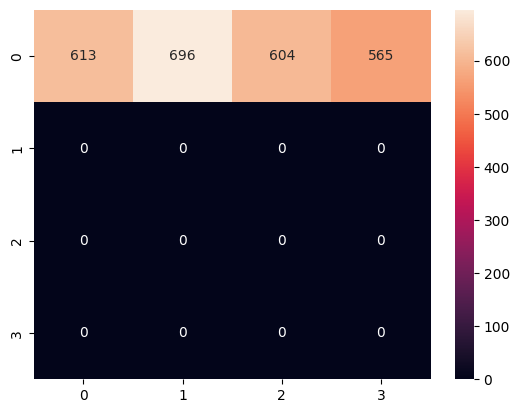

In [27]:
conf=confusion_matrix(preds_classes,np.argmax(y_test, axis=1))
sns.heatmap(conf, annot=True, fmt='d')

In [ ]:
???